In [1]:
import sys
sys.path.append('../')
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import pickle
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import permutations
import random
import os 

from utils.metrics import RMSE
import utils.metrics as metrics
from simulators.oup import oup

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

import warnings
warnings.filterwarnings('ignore')

cpu


In [28]:
# you can pre-generate the data using generate_data.py
N = 100

x = torch.tensor(np.load("../data/oup_x_4000.npy")).reshape(4000, N, 25).to(device)
theta = np.load("../data/oup_theta_4000.npy")

dataloader = DataLoader(x[:1000], batch_size=50, shuffle=True)

In [4]:
def regression_ABC(s_obs, param, sumStats, p):
    def mad(data):
        return np.mean(np.abs(data - np.mean(data, axis=0)), axis=0)

    if param.shape[0] < param.shape[1]:
        param = np.transpose(param)

    if sumStats.shape[0] < sumStats.shape[1]:
        sumStats = np.transpose(sumStats)
    
    M = len(param)
    M_epsilon = int(M*p)

    norm_factor = mad(sumStats)

    norm_sumStats = sumStats / norm_factor
    norm_s_obs = s_obs / norm_factor

    distance = np.linalg.norm(norm_sumStats - norm_s_obs, axis = 1)
    max_accepted_distance = np.sort(distance)[M_epsilon - 1]

    posterior_samples = param[distance <= max_accepted_distance, :]
    
    norm_sumStats_star = norm_sumStats[distance <= max_accepted_distance, :]

    weights = 1 - (distance[distance <= max_accepted_distance] / max_accepted_distance)**2
    W = np.diag(weights)

    s_obs_norm = np.tile(norm_s_obs, (M_epsilon,1))
    X = np.column_stack((np.ones(shape = (M_epsilon,1)), norm_sumStats_star - s_obs_norm))

    A = np.matmul(X.T, W)

    solution = np.linalg.solve(np.matmul(A, X), np.matmul(A, posterior_samples))

    beta = solution[1:,:]

    posterior_samples_adjusted = posterior_samples - np.matmul((norm_sumStats_star - s_obs_norm), beta)

    return posterior_samples_adjusted
    

In [5]:
def regression_ABC_robust(s_obs, param, sumStats, p, sum_net, simulator):
    def mad(data):
        return np.mean(np.abs(data - np.mean(data, axis=0)), axis=0)

    if param.shape[0] < param.shape[1]:
        param = np.transpose(param)

    if sumStats.shape[0] < sumStats.shape[1]:
        sumStats = np.transpose(sumStats)
    
    M = len(param)
    M_epsilon = int(M*p)

    norm_factor = mad(sumStats)

    norm_sumStats = sumStats / norm_factor
    norm_s_obs = s_obs / norm_factor

    distance = np.linalg.norm(norm_sumStats - norm_s_obs, axis = 1)
    max_accepted_distance = np.sort(distance)[M_epsilon - 1]

    posterior_samples = param[distance <= max_accepted_distance, :]
    
    norm_sumStats_star = norm_sumStats[distance <= max_accepted_distance, :]
    
    theta_obs_new = torch.tensor(np.mean(posterior_samples, axis=0))
    x_obs_new = simulator(theta_obs_new)
    s_obs_new = sum_net.forward_encoder(x_obs_new).cpu().detach().numpy().reshape(-1, 4)
    s_obs_new = np.mean(s_obs_new, axis=0)
    norm_s_obs_new = s_obs_new / norm_factor
    

    weights = 1 - (distance[distance <= max_accepted_distance] / max_accepted_distance)**2
    W = np.diag(weights)

    s_obs_norm = np.tile(norm_s_obs_new, (M_epsilon,1))
    X = np.column_stack((np.ones(shape = (M_epsilon,1)), norm_sumStats_star - s_obs_norm))

    A = np.matmul(X.T, W)

    solution = np.linalg.solve(np.matmul(A, X), np.matmul(A, posterior_samples))

    beta = solution[1:,:]

    posterior_samples_adjusted = posterior_samples - np.matmul((norm_sumStats_star - s_obs_norm), beta)

    return posterior_samples_adjusted

In [6]:
class OUPSummary(nn.Module):
    def __init__(self, input_size, hidden_dim, N):
        super(OUPSummary, self).__init__()
        self.N = N
        self.hidden_dim = hidden_dim
        self.input_size = input_size
        self.num_layers = 1

        self.encoder = nn.Sequential(nn.Conv1d(self.input_size, 4, 3, 2),
                                     nn.Conv1d(4, 4, 3, 2),
                                     nn.Conv1d(4, 4, 3, 3))
        
        self.decoder = nn.Sequential(nn.ConvTranspose1d(4, 4, 3, 3),
                                     nn.ConvTranspose1d(4, 4, 3, 2),
                                     nn.ConvTranspose1d(4, self.input_size, 3, 2),
                                     nn.Upsample(25))

    def forward(self, Y):

        batch_size = Y.size(0)
        embeddings = self.encoder(Y.reshape(-1, 1, 25))

        output = self.decoder(embeddings.reshape(-1, 4, 1)).reshape(-1, 100, 25)
        return output

    def forward_encoder(self, Y):
        embeddings = self.encoder(Y.reshape(-1, 1, 25)).reshape(-1, 100, 4)
        return embeddings

# ABC

In [7]:
def solve_normal():
    summary_net_normal = OUPSummary(1, 4, 100).to(device)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(summary_net_normal.parameters(), lr=0.01)

    # Train the model for some number of epochs
    num_epochs = 10
    for epoch in range(num_epochs):
        running_loss = 0.0
        for data in dataloader:
            inputs = data
            optimizer.zero_grad()

            outputs = summary_net_normal(inputs)

            loss = criterion(outputs, inputs)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {running_loss/len(dataloader)}")
    return summary_net_normal

# ABC-RS

In [8]:
def solve_robust(beta, obs_cont):
    summary_net_robust = OUPSummary(1, 4, 100).to(device)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(summary_net_robust.parameters(), lr=0.01)

    index_list = [int(i) for i in range(len(x))]

    num_epochs = 10
    for epoch in range(num_epochs):
        running_loss = 0.0
        for data in dataloader:
            inputs = data.to(device)
            optimizer.zero_grad()

            outputs = summary_net_robust(inputs)

            random.shuffle(index_list)
            context_embeddings = torch.mean(summary_net_robust.forward_encoder(x[index_list[:200]]), dim=1)

            obs_embeddings = torch.mean(summary_net_robust.forward_encoder(obs_cont), dim=1)

            ae_loss = criterion(outputs, inputs)
            summary_loss = metrics.MMD_unweighted(context_embeddings, obs_embeddings, lengthscale=metrics.median_heuristic(context_embeddings))

            loss = ae_loss + beta*summary_loss

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {running_loss/len(dataloader)}")
    return summary_net_robust

# Main training loop

In [114]:
degrees = [0, 0.1, 0.2]

for degree in degrees:
    obs_cont = torch.tensor(np.load(f"../data/oup_obs_{int(degree * 10)}.npy")).to(device)

    n_sims = 50
    beta_list = [1, 2, 3, 4, 5, 10]
    for beta in beta_list:
        for i in range(n_sims):
            print(f"Simulation {i}")
            summary_net_normal = solve_normal()
            s_normal = torch.mean(summary_net_normal.forward_encoder(x).cpu(), dim=1).detach().numpy()
            s_obs_normal = torch.mean(summary_net_normal.forward_encoder(obs_cont).cpu(), dim=1).detach().numpy()
            posterior_normal = regression_ABC(s_obs_normal, theta, s_normal, 0.05)

            summary_net_robust = solve_robust(beta, obs_cont)
            s_robust = torch.mean(summary_net_robust.forward_encoder(x).cpu(), dim=1).detach().numpy()
            s_obs_robust = torch.mean(summary_net_robust.forward_encoder(obs_cont).cpu(), dim=1).detach().numpy()
            posterior_robust = regression_ABC(s_obs_robust, theta, s_robust, 0.05)

            root_name = f'../objects/ABC/oup_final/degree={degree}/lambda={beta}/' + str(i+50)
            if not os.path.exists(root_name):
                os.makedirs(root_name)
            np.save(root_name + '/posterior_normal.npy', posterior_normal)
            np.save(root_name + '/posterior_robust.npy', posterior_robust)

Simulation 0
Epoch 1, Loss: 19.881811213493346
Epoch 2, Loss: 3.532411479949951
Epoch 3, Loss: 1.809911972284317
Epoch 4, Loss: 1.1307589948177337
Epoch 5, Loss: 0.8746300846338272
Epoch 6, Loss: 0.7223460108041764
Epoch 7, Loss: 0.5986285001039505
Epoch 8, Loss: 0.5087200284004212
Epoch 9, Loss: 0.47069440931081774
Epoch 10, Loss: 0.43337869495153425
Epoch 1, Loss: 29.270949935913087
Epoch 2, Loss: 13.374708557128907
Epoch 3, Loss: 11.585823154449463
Epoch 4, Loss: 12.511240577697754
Epoch 5, Loss: 11.151721000671387
Epoch 6, Loss: 10.622548007965088
Epoch 7, Loss: 10.392054653167724
Epoch 8, Loss: 10.322565031051635
Epoch 9, Loss: 10.233721208572387
Epoch 10, Loss: 9.496375608444215
Simulation 1
Epoch 1, Loss: 12.83436107635498
Epoch 2, Loss: 2.8397700071334837
Epoch 3, Loss: 1.8739984810352326
Epoch 4, Loss: 1.2192168980836868
Epoch 5, Loss: 0.7864373445510864
Epoch 6, Loss: 0.5659593299031258
Epoch 7, Loss: 0.48766393065452573
Epoch 8, Loss: 0.45492687821388245
Epoch 9, Loss: 0.432

Epoch 9, Loss: 8.62940697669983
Epoch 10, Loss: 8.360639309883117
Simulation 12
Epoch 1, Loss: 22.15260672569275
Epoch 2, Loss: 3.8771143317222596
Epoch 3, Loss: 1.2394429296255112
Epoch 4, Loss: 0.8211647182703018
Epoch 5, Loss: 0.688102638721466
Epoch 6, Loss: 0.6104256778955459
Epoch 7, Loss: 0.5703952237963676
Epoch 8, Loss: 0.559389029443264
Epoch 9, Loss: 0.5011553958058357
Epoch 10, Loss: 0.46757612079381944
Epoch 1, Loss: 28.294895935058594
Epoch 2, Loss: 16.012707567214967
Epoch 3, Loss: 12.48873267173767
Epoch 4, Loss: 11.361793804168702
Epoch 5, Loss: 10.795698404312134
Epoch 6, Loss: 9.703923797607422
Epoch 7, Loss: 9.43782410621643
Epoch 8, Loss: 9.292079401016235
Epoch 9, Loss: 8.979168367385864
Epoch 10, Loss: 8.923430490493775
Simulation 13
Epoch 1, Loss: 18.343033456802367
Epoch 2, Loss: 3.4206849932670593
Epoch 3, Loss: 2.410138100385666
Epoch 4, Loss: 1.7088916599750519
Epoch 5, Loss: 1.0569690972566606
Epoch 6, Loss: 0.7960873395204544
Epoch 7, Loss: 0.5947079479694

Epoch 7, Loss: 11.031202602386475
Epoch 8, Loss: 10.211973333358765
Epoch 9, Loss: 9.917944049835205
Epoch 10, Loss: 9.857034349441529
Simulation 24
Epoch 1, Loss: 13.317229151725769
Epoch 2, Loss: 3.2254610776901247
Epoch 3, Loss: 2.3143147349357607
Epoch 4, Loss: 1.5673585176467895
Epoch 5, Loss: 0.8070118755102158
Epoch 6, Loss: 0.5769831612706184
Epoch 7, Loss: 0.4621900156140327
Epoch 8, Loss: 0.41529642343521117
Epoch 9, Loss: 0.39250491708517077
Epoch 10, Loss: 0.38205525279045105
Epoch 1, Loss: 33.95755643844605
Epoch 2, Loss: 18.07716660499573
Epoch 3, Loss: 11.685321760177612
Epoch 4, Loss: 10.933331108093261
Epoch 5, Loss: 10.424515676498412
Epoch 6, Loss: 10.263434743881225
Epoch 7, Loss: 9.774671077728271
Epoch 8, Loss: 9.795002937316895
Epoch 9, Loss: 9.5087721824646
Epoch 10, Loss: 9.459809589385987
Simulation 25
Epoch 1, Loss: 17.46295621395111
Epoch 2, Loss: 3.5293792366981505
Epoch 3, Loss: 2.5255898118019102
Epoch 4, Loss: 1.9005892515182494
Epoch 5, Loss: 1.10938724

Epoch 5, Loss: 10.369301414489746
Epoch 6, Loss: 10.289048767089843
Epoch 7, Loss: 9.75188422203064
Epoch 8, Loss: 9.846062755584716
Epoch 9, Loss: 9.863604974746703
Epoch 10, Loss: 9.186479377746583
Simulation 36
Epoch 1, Loss: 20.123079586029053
Epoch 2, Loss: 3.660288941860199
Epoch 3, Loss: 1.8980073869228362
Epoch 4, Loss: 1.0776571601629257
Epoch 5, Loss: 0.7986113667488098
Epoch 6, Loss: 0.6942208886146546
Epoch 7, Loss: 0.6179380983114242
Epoch 8, Loss: 0.5523778825998307
Epoch 9, Loss: 0.4991849049925804
Epoch 10, Loss: 0.4633147805929184
Epoch 1, Loss: 31.918017196655274
Epoch 2, Loss: 14.950517606735229
Epoch 3, Loss: 11.841951465606689
Epoch 4, Loss: 12.24426302909851
Epoch 5, Loss: 10.706746673583984
Epoch 6, Loss: 10.128526830673218
Epoch 7, Loss: 9.817775392532349
Epoch 8, Loss: 9.226937580108643
Epoch 9, Loss: 9.269703269004822
Epoch 10, Loss: 8.848804664611816
Simulation 37
Epoch 1, Loss: 18.913267064094544
Epoch 2, Loss: 3.3304885983467103
Epoch 3, Loss: 2.33076756000

Epoch 3, Loss: 11.8536808013916
Epoch 4, Loss: 11.279225063323974
Epoch 5, Loss: 11.40904483795166
Epoch 6, Loss: 10.837165117263794
Epoch 7, Loss: 10.941155910491943
Epoch 8, Loss: 10.461021995544433
Epoch 9, Loss: 10.205472946166992
Epoch 10, Loss: 10.282069635391235
Simulation 48
Epoch 1, Loss: 14.41789207458496
Epoch 2, Loss: 3.3104146480560304
Epoch 3, Loss: 2.512593913078308
Epoch 4, Loss: 2.283045929670334
Epoch 5, Loss: 2.161081004142761
Epoch 6, Loss: 1.9410422027111054
Epoch 7, Loss: 1.6080795526504517
Epoch 8, Loss: 1.0734470814466477
Epoch 9, Loss: 0.6367758408188819
Epoch 10, Loss: 0.46714688986539843
Epoch 1, Loss: 39.0826657295227
Epoch 2, Loss: 15.798070430755615
Epoch 3, Loss: 12.173673248291015
Epoch 4, Loss: 10.678252172470092
Epoch 5, Loss: 10.350865411758424
Epoch 6, Loss: 10.093034982681274
Epoch 7, Loss: 9.810330772399903
Epoch 8, Loss: 9.68173565864563
Epoch 9, Loss: 9.293409395217896
Epoch 10, Loss: 8.942288970947265
Simulation 49
Epoch 1, Loss: 14.242548537254

In [61]:
beta = 5
simulator = oup(N=1)
mmd_normal = np.zeros(n_sims)
mmd_robust = np.zeros(n_sims)
obs = torch.tensor(np.load(f"../data/oup_obs_2.npy"))
obs_stat = torch.tensor(temporalMomentsGeneral(obs.reshape(100, 25)))

for i in range(n_sims):
    root_name = root_name = f'../objects/ABC/oup/degree=0.2/lambda={beta}/' + str(i)
    posterior_normal = torch.tensor(np.load(root_name + '/posterior_normal.npy'))
    posterior_robust = torch.tensor(np.load(root_name + '/posterior_robust.npy'))
    
    predictive_normal = torch.zeros(200, 25)
    for j in range(200):
        predictive_normal[j] = simulator(posterior_normal[j])[0]
    
    pred_stat_normal = torch.tensor(temporalMomentsGeneral(predictive_normal))
    
    predictive_robust = torch.zeros(200, 25)
    for j in range(200):
        predictive_robust[j] = simulator(posterior_robust[j])[0]
    
    pred_stat_robust = torch.tensor(temporalMomentsGeneral(predictive_robust))
    
    mmd_normal[i] = float(metrics.MMD_unweighted(pred_stat_normal, obs_stat, 
                           lengthscale=metrics.median_heuristic(obs_stat)))
    
    mmd_robust[i] = float(metrics.MMD_unweighted(pred_stat_robust, obs_stat, 
                           lengthscale=metrics.median_heuristic(obs_stat)))

print("RMSE mean for normal model: ", np.mean(rmse_normal))
print("RMSE mean for robust model: ", np.mean(rmse_robust))
print("RMSE std for normal model: ", np.std(rmse_normal))
print("RMSE std for robust model: ", np.std(rmse_robust))

RMSE mean for normal model:  5.511557160673599
RMSE mean for robust model:  1.0978619629178465
RMSE std for normal model:  2.457881610621534
RMSE std for robust model:  0.24876219083298912


In [18]:
degree = 0.1
obs_cont = torch.tensor(np.load(f"../data/oup_obs_{int(degree * 10)}.npy")).to(device)
simulator = oup(N=100)

In [21]:
summary_net_normal = solve_normal()
s_normal = torch.mean(summary_net_normal.forward_encoder(x).cpu(), dim=1).detach().numpy()
s_obs_normal = torch.mean(summary_net_normal.forward_encoder(obs_cont).cpu(), dim=1).detach().numpy()

posterior_robust_abc = regression_ABC(s_obs_normal, theta, s_normal, 0.05)

print("RMSE", RMSE(torch.tensor([0.5, 1.0]), posterior_robust_abc, 2).detach().numpy())

Epoch 1, Loss: 19.74319484233856
Epoch 2, Loss: 4.3521126985549925
Epoch 3, Loss: 2.4785762071609496
Epoch 4, Loss: 2.0264603793621063
Epoch 5, Loss: 1.3570656955242157
Epoch 6, Loss: 0.9148211568593979
Epoch 7, Loss: 0.765341830253601
Epoch 8, Loss: 0.6433185130357743
Epoch 9, Loss: 0.547941941022873
Epoch 10, Loss: 0.5040055871009826
RMSE 1.844684229182165


In [22]:
summary_net_robust = solve_robust(20, obs_cont)
s_robust = torch.mean(summary_net_robust.forward_encoder(x).cpu(), dim=1).detach().numpy()
s_obs_robust = torch.mean(summary_net_robust.forward_encoder(obs_cont).cpu(), dim=1).detach().numpy()
posterior_robust = regression_ABC(s_obs_robust, theta, s_robust, 0.05)

print("RMSE", RMSE(torch.tensor([0.5, 1.0]), posterior_robust, 2).detach().numpy())

Epoch 1, Loss: 33.54846591949463
Epoch 2, Loss: 24.547700071334837
Epoch 3, Loss: 16.12728419303894
Epoch 4, Loss: 12.189438152313233
Epoch 5, Loss: 10.932768154144288
Epoch 6, Loss: 10.894769525527954
Epoch 7, Loss: 11.268437099456786
Epoch 8, Loss: 12.054446363449097
Epoch 9, Loss: 11.255282926559449
Epoch 10, Loss: 11.614726686477661
RMSE 0.734429686772486


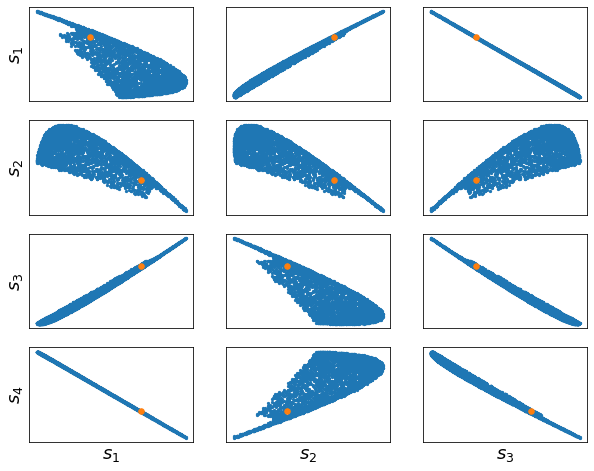

In [25]:
stat = list(permutations(range(4), 2))

plt.figure(figsize=(10, 8))
for i in range(len(stat)):
    plt.subplot(4, 3, i+1)
    plt.scatter(s_normal[:, stat[i][1]], s_normal[:, stat[i][0]], s=5)
    plt.scatter(s_obs_normal[0, stat[i][1]], s_obs_normal[0, stat[i][0]], s=30)
    plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
    if i%3==0:
        plt.ylabel("$s_{i}$".format(i=stat[i][0]+1), fontsize=18)
    if len(stat)-3 <= i < len(stat):
        plt.xlabel("$s_{i}$".format(i=stat[i][1]+1), fontsize=18, fontweight="bold")

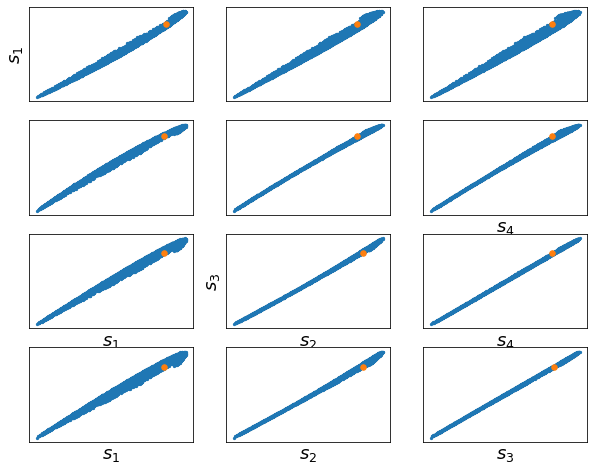

In [24]:
stat = list(permutations(range(4), 2))
plt.figure(figsize=(10, 8))
for i in range(len(stat)):
    plt.subplot(4, 3, i+1)
    plt.scatter(s_robust[:, stat[i][1]], s_robust[:, stat[i][0]], s=5)
    plt.scatter(s_obs_robust[0, stat[i][1]], s_obs_robust[0, stat[i][0]], s=30)
    plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False)
    if i%7==0:
        plt.ylabel("$s_{i}$".format(i=stat[i][0]+1), fontsize=18)
    if len(stat)-7 <= i < len(stat):
        plt.xlabel("$s_{i}$".format(i=stat[i][1]+1), fontsize=18, fontweight="bold")


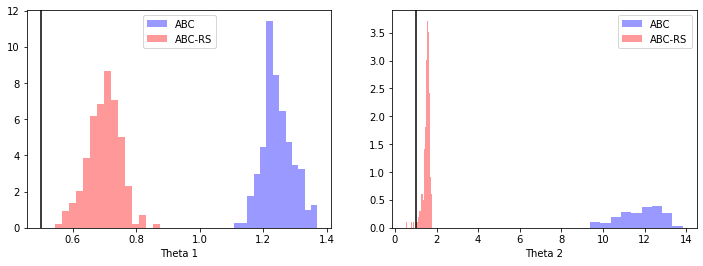

In [27]:
degree = 0.2

obs_cont = torch.tensor(np.load(f"../data/oup_obs_{int(degree * 10)}.npy")).to(device)

posterior_normal = np.load("../objects/ABC/oup_final/degree=0.2/lambda=10/2/posterior_normal.npy")
posterior_robust = np.load("../objects/ABC/oup_final/degree=0.1/lambda=15/27/posterior_robust.npy")
theta_gt = [0.5 ,1.0]

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.axvline(x=theta_gt[0],ls="-",c="black")
sns.distplot(posterior_normal[:, 0], color='blue', kde=False, norm_hist=True, label="ABC")
sns.distplot(posterior_robust[:, 0], color='red', kde=False, norm_hist=True, label="ABC-RS")
# sns.distplot(posterior_robust_abc[:, 0], color='green', kde=False, norm_hist=True, label="robust ABC")
plt.legend()
# plt.xlim(2, 8)
plt.xlabel("Theta 1")

plt.subplot(1, 2, 2)
plt.axvline(x=theta_gt[1],ls="-",c="black")
sns.distplot(posterior_normal[:, 1], color='blue', kde=False, norm_hist=True, label="ABC")
sns.distplot(posterior_robust[:, 1], color='red', kde=False, norm_hist=True, label="ABC-RS")
plt.legend()
# plt.xlim(0, 25)
plt.xlabel("Theta 2")

plt.show()